# Scoring Model : classification model that is used to calculate the probablity of an event to take place and assigning a score accordingly

### Objective: Probability of Default(PD)

#### Import the required libraries:

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import statistics 
import scipy.stats
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

#import scikit metrics:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc

%matplotlib inline


#### Importing the dataset:

In [2]:
# Loading the dataset using pandas
adc = pd.read_excel('C:\\HTW-SEM-I\\MPMD1.2_DA\\project\\adc.xlsx')

In [3]:
# Setting the display option for 150 rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)

# 1. Dataset Assessment

* Exploring dataset
* Checking for Missing values and fill null values with 0s
* Checking for Duplicates
* Checking for the target counts
* Checking for categorical variable counts
* Details of each categorical variables with loan_amount

In [4]:
# Looking at first 5 rows of dataset
adc.head()

,loan_status_2,loan_status,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
0,Charged off,1,35000,60,17.86,886.11,D5,4.0,MORTGAGE,80000.0,Verified,2015-01-02,debt_consolidation,GA,22.20,740,744,18,0,31705,64.6,2.0,0.0,27,2
1,Charged off,1,25000,60,14.85,592.79,C5,10.0,RENT,75000.0,Not Verified,2016-01-01,debt_consolidation,CT,31.42,705,709,14,0,38312,75.6,0.0,0.0,29,-1
2,Fully paid,0,5000,36,10.15,161.69,B2,NaN,MORTGAGE,16344.0,Verified,2014-01-05,debt_consolidation,FL,24.89,660,664,8,1,4859,51.1,3.0,1.0,33,0
3,Fully paid,0,22000,60,15.59,530.22,C5,10.0,MORTGAGE,80000.0,Not Verified,2016-01-09,debt_consolidation,TX,15.80,675,679,15,1,17824,52.0,2.0,0.0,36,0
4,Fully paid,0,25000,36,6.89,770.68,A3,NaN,OWN,59000.0,Verified,2015-01-07,debt_consolidation,WI,16.01,735,739,15,0,50115,37.9,2.0,0.0,56,-1


In [5]:
# Checking for datatypes for columns and null_counts in the dataset
adc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_status_2         58852 non-null  object        
 1   loan_status           58852 non-null  int64         
 2   loan_amnt             58852 non-null  int64         
 3   term                  58852 non-null  int64         
 4   int_rate              58852 non-null  float64       
 5   installment           58852 non-null  float64       
 6   sub_grade             58852 non-null  object        
 7   emp_length            55510 non-null  float64       
 8   home_ownership        58852 non-null  object        
 9   annual_inc            58852 non-null  float64       
 10  verification_status   58852 non-null  object        
 11  issue_d               58852 non-null  datetime64[ns]
 12  purpose               58852 non-null  object        
 13  addr_state      

In [6]:
# Looking for Duplicate counts in dataset
adc.duplicated().sum()

0

In [7]:
# Percentage of missing values in each column. 
adc.isna().sum()/len(adc)*100

loan_status_2           0.000000
loan_status             0.000000
loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
sub_grade               0.000000
emp_length              5.678652
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
purpose                 0.000000
addr_state              0.000000
dti                     0.000000
fico_range_low          0.000000
fico_range_high         0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.056073
mort_acc                3.464623
pub_rec_bankruptcies    0.045878
age                     0.000000
pay_status              0.000000
dtype: float64

In [8]:
# Check value counts for target variable 
adc['loan_status'].value_counts()

0    47080
1    11772
Name: loan_status, dtype: int64

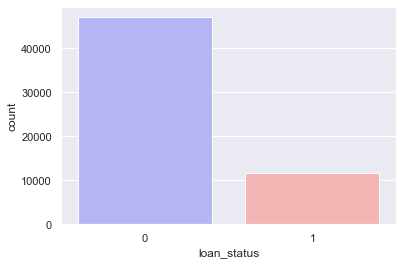

In [9]:
sns.countplot(data=adc,x='loan_status', palette='bwr')

In [10]:
# Dropping static features
adc.drop(columns = ['loan_status_2', 'issue_d', 'addr_state' ], inplace = True)

In [11]:
# Filling 0s for missing values. 
adc.fillna(value = 0, inplace = True)

In [12]:
# Checking the category of home_ownership
adc['home_ownership'].value_counts()

MORTGAGE    28993
RENT        23499
OWN          6340
ANY             9
OTHER           8
NONE            3
Name: home_ownership, dtype: int64

In [13]:
adc['verification_status'].value_counts()

Source Verified    23085
Verified           18019
Not Verified       17748
Name: verification_status, dtype: int64

In [14]:
adc['purpose'].value_counts()

debt_consolidation    33998
credit_card           13148
home_improvement       3738
other                  3464
major_purchase         1290
small_business          669
medical                 649
car                     608
vacation                420
moving                  387
house                   325
wedding                 103
renewable_energy         38
educational              15
Name: purpose, dtype: int64

In [15]:
adc['sub_grade'].value_counts()

B3    3675
B5    3637
C1    3594
B4    3565
C2    3381
C3    3316
C4    3235
B2    3233
B1    3154
A5    2909
C5    2879
A4    2386
D1    2233
A1    1995
D2    1944
D3    1740
A3    1675
D4    1600
A2    1586
D5    1293
E1    1061
E2     907
E3     802
E4     684
E5     600
F1     449
F2     297
F3     245
F4     201
F5     177
G1     116
G2     100
G3      87
G4      53
G5      43
Name: sub_grade, dtype: int64

In [16]:
# Finding the mean, median and count for home_ownership vs loan_amount
adc.groupby(['home_ownership'])[['loan_amnt']].agg(['mean','median','count'])

loan_amnt              
                        mean median  count
home_ownership                            
ANY             10019.444444  11200      9
MORTGAGE        15810.045528  14825  28993
NONE            13125.000000  12375      3
OTHER           12550.000000  11600      8
OWN             13762.231861  12000   6340
RENT            12537.422869  10375  23499

In [17]:
# Finding the mean, median and count for verification_status vs loan_amount
adc.groupby(['verification_status'])[['loan_amnt']].agg(['mean','median','count'])

loan_amnt              
                             mean median  count
verification_status                            
Not Verified         11566.349730  10000  17748
Source Verified      14677.537362  12300  23085
Verified             16447.612243  15000  18019

In [18]:
# Finding the mean, median and count for purpose vs loan_amount
adc.groupby(['purpose'])[['loan_amnt']].agg(['mean','median','count'])

loan_amnt              
                            mean median  count
purpose                                       
car                  8736.307566   7000    608
credit_card         14563.591421  12000  13148
debt_consolidation  15100.969175  13500  33998
educational          7770.000000   6000     15
home_improvement    14061.329588  12000   3738
house               16130.538462  14000    325
major_purchase      11658.100775   9000   1290
medical              8480.546995   7000    649
moving               7995.478036   5600    387
other                9870.691397   7200   3464
renewable_energy     9131.578947   6500     38
small_business      15571.487294  13950    669
vacation             6338.154762   5000    420
wedding             10755.339806   8875    103

In [19]:
# Finding the mean, median and count for sub_grade vs loan_amount
adc.groupby(['sub_grade'])[['loan_amnt']].agg(['mean','median','count'])

loan_amnt               
                   mean   median count
sub_grade                             
A1         13856.929825  12200.0  1995
A2         13397.399117  12000.0  1586
A3         13259.910448  12000.0  1675
A4         13733.644174  12000.0  2386
A5         13952.887590  12000.0  2909
B1         12989.172479  11000.0  3154
B2         13202.049180  11500.0  3233
B3         13269.312925  11700.0  3675
B4         13233.899018  11200.0  3565
B5         12870.827605  10400.0  3637
C1         13422.015860  11200.0  3594
C2         13784.057971  12000.0  3381
C3         14219.126960  12000.0  3316
C4         14669.667697  12600.0  3235
C5         14721.370267  12375.0  2879
D1         14714.252127  12400.0  2233
D2         14621.013374  12175.0  1944
D3         14979.267241  12950.0  1740
D4         15531.796875  14400.0  1600
D5         15929.891725  14000.0  1293
E1         17145.829406  15600.0  1061
E2         17303.197354  15775.0   907
E3         17225.374065  15625.0   802
E4         18013.523392  17175.0   684
E5         18079.541667  16875.0   600
F1         18255.233853  17700.0   449
F2         19089.730640  19050.0   297
F3         18699.897959  17875.0   245
F4         20429.726368  20000.0   201
F5         20235.734463  20000.0   177
G1         19737.068966  17812.5   116
G2         18226.250000  16975.0   100
G3         20648.275862  20300.0    87
G4         22005.188679  21000.0    53
G5         21156.395349  21000.0    43

In [20]:
# Check category counts for pay_status
adc['pay_status'].value_counts()

 0    28101
-1    10708
 1     8710
 2     5327
-2     4810
 3      892
 4      174
 5       53
 8       37
 6       21
 7       18
 9        1
Name: pay_status, dtype: int64

## Dataset Assesment Summary

 **- No Duplicates found**<br>
 **- Dataset has 58852 Rows and 25 Columns**<br>
 **- Missing values found in 4 columns:**
            1. 'emp_length' =  5.67% : This is highest null count 
            2. 'mort_acc' = 3.46% 
            3. 'revol_util' = 0.056%
            4. 'pub_rec_bankruptcies' =  0.045%
 **- Target Variable: 'loan_status', Default = 1, No Default = 0**<br>
            1. Non Defaults count:   47080
            2. Defaults count:       11772
 **- Imbalance Dataset because Non Defaults are higher than Defaults count**<br>
 **- Category Values: **<br>
            1. home_ownership
            2. verification_status
            3. purpose
            4. sub_grade

 ## Dataset Cleaning Summary
 
 **- Dropped Static features: 'loan_status_2', 'issue_d', 'addr_state'**<br>
 **- Fillna used to fill null values with 0s instead of dropping, since the missing value counts are not significant**<br>
 

# 2. Variable Selection

* Information value
* Trend
* Correlation 
* Penalised
* regression

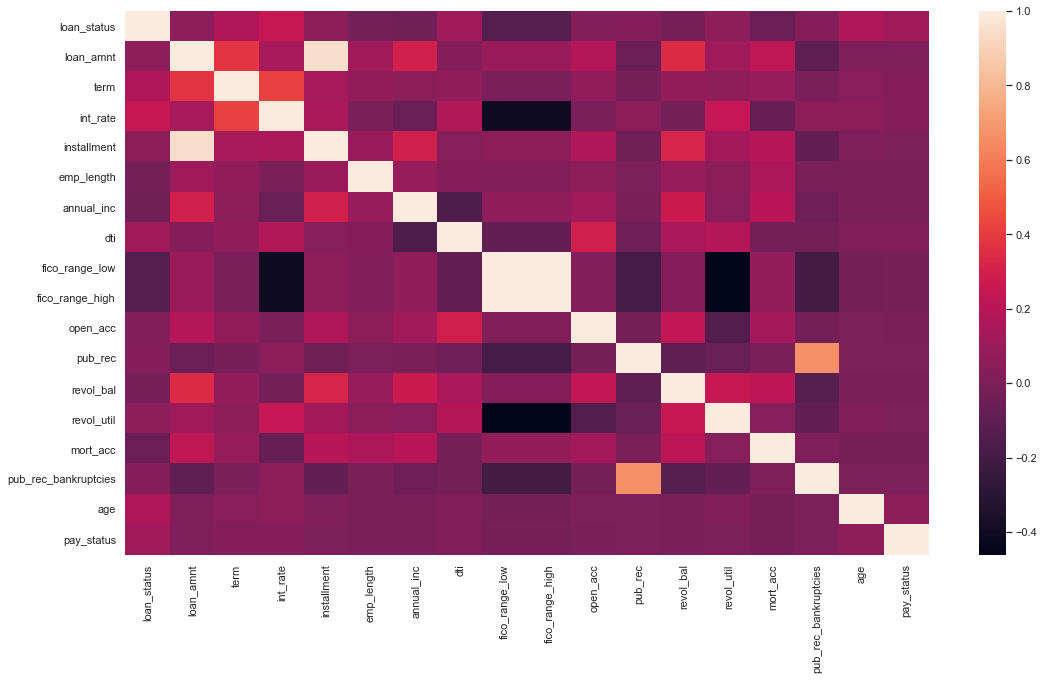

In [21]:
# calculate the correlation matrix
corr = adc.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [22]:
#Information Value(IV) Calculations for Categories in the dataset:

# .02 To .1  -> Weak predictive power
# 0.1 To 0.3 -> Medium Predictive Power
# 0.3 To 0.5 -> Strong Predictive Power
# 0.5 abve   -> suspecious Predictive Power


def get_woe_iv(feature, target):
    woe_iv = (pd.crosstab(adc[feature],adc[target], normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    print(woe_iv)

In [23]:
# Checking IV for home_ownership feature with target
get_woe_iv('home_ownership', 'loan_status') # weak predictor

loan_status            0         1       woe        iv
home_ownership                                        
ANY             0.000170  0.000085 -0.693317  0.032927
MORTGAGE        0.509792  0.424057 -0.184134  0.032927
NONE            0.000021  0.000170  2.079272  0.032927
OTHER           0.000106  0.000255  0.875299  0.032927
OWN             0.107392  0.109072  0.015529  0.032927
RENT            0.382519  0.466361  0.198181  0.032927


In [24]:
# Checking IV for verification_status feature with target
get_woe_iv('verification_status', 'loan_status') # weak predictor

loan_status                 0         1       woe        iv
verification_status                                        
Not Verified         0.322239  0.218909 -0.386635  0.058208
Source Verified      0.385939  0.417516  0.078644  0.058208
Verified             0.291822  0.363575  0.219839  0.058208


In [25]:
# Checking IV for purpose feature with target
get_woe_iv('purpose', 'loan_status') # Not Useful

loan_status                0         1       woe        iv
purpose                                                   
car                 0.010854  0.008240 -0.275534  0.019012
credit_card         0.232137  0.188498 -0.208239  0.019012
debt_consolidation  0.568925  0.612725  0.074167  0.019012
educational         0.000276  0.000170 -0.485678  0.019012
home_improvement    0.064316  0.060313 -0.064268  0.019012
house               0.005544  0.005437 -0.019513  0.019012
major_purchase      0.022260  0.020557 -0.079577  0.019012
medical             0.010896  0.011553  0.058503  0.019012
moving              0.006393  0.007305  0.133361  0.019012
other               0.058624  0.059803  0.019917  0.019012
renewable_energy    0.000658  0.000595 -0.101953  0.019012
small_business      0.009813  0.017584  0.583278  0.019012
vacation            0.007370  0.006201 -0.172741  0.019012
wedding             0.001933  0.001019 -0.639828  0.019012


In [26]:
# Checking IV for sub_grade feature with target
get_woe_iv('sub_grade', 'loan_status') # strong predictor

loan_status         0         1       woe        iv
sub_grade                                          
A1           0.040867  0.006031 -1.913357  0.466201
A2           0.031988  0.006796 -1.549061  0.466201
A3           0.033602  0.007900 -1.447721  0.466201
A4           0.046771  0.015630 -1.096061  0.466201
A5           0.056372  0.021662 -0.956435  0.466201
B1           0.060153  0.027353 -0.788062  0.466201
B2           0.060514  0.032620 -0.617956  0.466201
B3           0.066822  0.044937 -0.396774  0.466201
B4           0.063488  0.048930 -0.260462  0.466201
B5           0.063955  0.053177 -0.184553  0.466201
C1           0.061810  0.058104 -0.061826  0.466201
C2           0.057370  0.057764  0.006840  0.466201
C3           0.054482  0.063795  0.157816  0.466201
C4           0.052251  0.065834  0.231071  0.466201
C5           0.045986  0.060652  0.276832  0.466201
D1           0.034388  0.052158  0.416555  0.466201
D2           0.029184  0.048420  0.506279  0.466201
D3          

In [27]:
#features to drop due to weak correlation: ['purpose', 'fico_range_low', 'fico_range_high'] 

adc.drop(columns = ['purpose', 'fico_range_low', 'fico_range_high'] , inplace = True)

In [28]:
#splitting datatset into: target and features

target = adc['loan_status']
features = adc.drop('loan_status', axis=1)

In [29]:
# Checking first 5 rows of target
target.head()

0    1
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [30]:
# Checking first 5 rows of features
features.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
0,35000,60,17.86,886.11,D5,4.0,MORTGAGE,80000.0,Verified,22.20,18,0,31705,64.6,2.0,0.0,27,2
1,25000,60,14.85,592.79,C5,10.0,RENT,75000.0,Not Verified,31.42,14,0,38312,75.6,0.0,0.0,29,-1
2,5000,36,10.15,161.69,B2,0.0,MORTGAGE,16344.0,Verified,24.89,8,1,4859,51.1,3.0,1.0,33,0
3,22000,60,15.59,530.22,C5,10.0,MORTGAGE,80000.0,Not Verified,15.80,15,1,17824,52.0,2.0,0.0,36,0
4,25000,36,6.89,770.68,A3,0.0,OWN,59000.0,Verified,16.01,15,0,50115,37.9,2.0,0.0,56,-1


In [31]:
#look for outliers in features selected:
features.describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
count,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,5.885200e+04,58852.000000,58852.000000,58852.000000,5.885200e+04,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000
mean,14281.248726,41.646435,13.184463,434.544837,5.645993,7.673213e+04,17.993072,11.623122,0.216781,1.619697e+04,51.938696,1.621678,0.134473,35.285309,0.054883
std,8617.247099,10.180077,4.752709,258.650524,3.837227,7.390182e+04,8.339486,5.471044,0.589514,2.113372e+04,24.458518,2.010912,0.381288,9.361171,1.136492
min,1000.000000,36.000000,5.310000,30.650000,0.000000,6.695000e+03,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,20.000000,-2.000000
25%,7800.000000,36.000000,9.670000,247.290000,2.000000,4.600000e+04,11.767500,8.000000,0.000000,6.009000e+03,33.700000,0.000000,0.000000,28.000000,-1.000000
50%,12000.000000,36.000000,12.730000,373.220000,6.000000,6.500000e+04,17.520000,11.000000,0.000000,1.111050e+04,52.400000,1.000000,0.000000,34.000000,0.000000
75%,20000.000000,36.000000,15.990000,572.602500,10.000000,9.050000e+04,23.870000,14.000000,0.000000,1.983625e+04,70.800000,3.000000,0.000000,41.000000,1.000000
max,40000.000000,60.000000,30.990000,1607.800000,10.000000,6.998721e+06,49.940000,67.000000,21.000000,1.044210e+06,162.000000,24.000000,8.000000,78.000000,9.000000


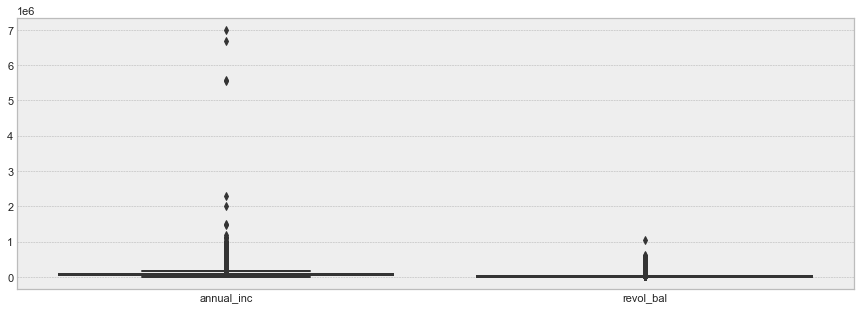

In [32]:
#plot boxplot for the 'annual_inc' and 'revol_bal'
plt.style.use('bmh')
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=features[['annual_inc', 'revol_bal']])

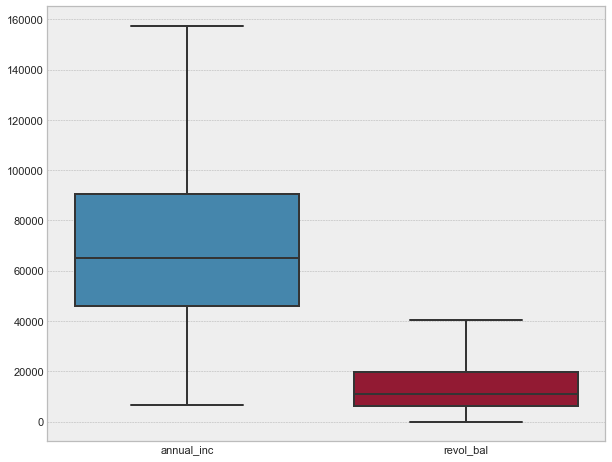

In [33]:
# calculate inter quartile ration for getting upper bound:

q1, q3= np.percentile(features['annual_inc'], [25,75])
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

#clipped extremes:
features['annual_inc']=features['annual_inc'].clip(lower=lower_bound)
features['annual_inc']=features['annual_inc'].clip(upper=upper_bound)

q1, q3= np.percentile(features['revol_bal'], [25,75])
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

#clipped extremes:
features['revol_bal']=features['revol_bal'].clip(lower=lower_bound)
features['revol_bal']=features['revol_bal'].clip(upper=upper_bound)



#plot boxplot:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=features[['annual_inc', 'revol_bal']])

## Summary Status of Feature Selection

**- Correlation Matrix shows that interest_rate, term and age are comparatively correlated with loan_status**<br>
**- Information Value shows strong predictive power for features 'sub_grade' and 'loan_status'**<br>
**- Finding outliers using box_plot and removing the outliers using IQR (InterQuartile Range)**<br>



# 3. Feature Engineering

* Binning
* Transformation

In [34]:
features.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
0,35000,60,17.86,886.11,D5,4.0,MORTGAGE,80000.0,Verified,22.20,18,0,31705.000,64.6,2.0,0.0,27,2
1,25000,60,14.85,592.79,C5,10.0,RENT,75000.0,Not Verified,31.42,14,0,38312.000,75.6,0.0,0.0,29,-1
2,5000,36,10.15,161.69,B2,0.0,MORTGAGE,16344.0,Verified,24.89,8,1,4859.000,51.1,3.0,1.0,33,0
3,22000,60,15.59,530.22,C5,10.0,MORTGAGE,80000.0,Not Verified,15.80,15,1,17824.000,52.0,2.0,0.0,36,0
4,25000,36,6.89,770.68,A3,0.0,OWN,59000.0,Verified,16.01,15,0,40577.125,37.9,2.0,0.0,56,-1


In [35]:
# checking term (number of payments) value counts
features['term'].value_counts()


36    45006
60    13846
Name: term, dtype: int64

In [36]:
#variables to be quantize: ['term', 'emp_length', 'int_rate', 'annual_inc', 'dti',  'revol_bal', 'revol_util',]

# term is quantized into 2 bins 
features['term_36'] = np.where((features['term'] == 36), 1, 0)
features['term_60'] = np.where((features['term'] == 60), 1, 0)

In [37]:
features['emp_length'].value_counts()

10.0    19540
0.0      7956
2.0      5378
3.0      4739
1.0      3831
5.0      3651
4.0      3540
6.0      2820
8.0      2662
7.0      2586
9.0      2149
Name: emp_length, dtype: int64

In [38]:
# emp_length is quantized into 6 bins 
features['emp_length_0to1'] = np.where((features['emp_length'] >= 0.0 ) & (features['emp_length'] < 2.0), 1, 0)
features['emp_length_2to3'] = np.where((features['emp_length'] >= 2.0 ) & (features['emp_length'] < 4.0), 1, 0)
features['emp_length_4to5'] = np.where((features['emp_length'] >= 4.0 ) & (features['emp_length'] < 6.0), 1, 0)
features['emp_length_6to7'] = np.where((features['emp_length'] >= 6.0 ) & (features['emp_length'] < 7.0), 1, 0)
features['emp_length_8to9'] = np.where((features['emp_length'] >= 7.0 ) & (features['emp_length'] < 8.00), 1, 0)
features['emp_length_9to10'] = np.where((features['emp_length'] >= 8.0 ) & (features['emp_length'] < 10.00), 1, 0)


In [39]:
# int_rate is quantized into bins using qcut standard function. 
features['int_rate_qcut'] = pd.qcut(features['int_rate'], q=[0, .2, .4, .6, .8, 1], 
                                    labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [40]:
# annual_inc is quantized into bins using qcut standard function. 
features['annual_inc_qcut'] = pd.qcut(features['annual_inc'], q=[0, .2, .4, .6, .8, 1],
                                      labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [41]:
# revol_bal is quantized into bins using qcut standard function. 
features['revol_bal_qcut'] = pd.qcut(features['revol_bal'], q=[0, .2, .4, .6, .8, 1], 
                                     labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [42]:
# revol_util is quantized into bins using qcut standard function. 
features['revol_util_qcut'] = pd.qcut(features['revol_util'], q=[0, .2, .4, .6, .8, 1], 
                                      labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [43]:
features.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status,term_36,term_60,emp_length_0to1,emp_length_2to3,emp_length_4to5,emp_length_6to7,emp_length_8to9,emp_length_9to10,int_rate_qcut,annual_inc_qcut,revol_bal_qcut,revol_util_qcut
0,35000,60,17.86,886.11,D5,4.0,MORTGAGE,80000.0,Verified,22.20,18,0,31705.000,64.6,2.0,0.0,27,2,0,1,0,0,1,0,0,0,q5,q4,q5,q4
1,25000,60,14.85,592.79,C5,10.0,RENT,75000.0,Not Verified,31.42,14,0,38312.000,75.6,0.0,0.0,29,-1,0,1,0,0,0,0,0,0,q4,q3,q5,q5
2,5000,36,10.15,161.69,B2,0.0,MORTGAGE,16344.0,Verified,24.89,8,1,4859.000,51.1,3.0,1.0,33,0,1,0,1,0,0,0,0,0,q2,q1,q1,q3
3,22000,60,15.59,530.22,C5,10.0,MORTGAGE,80000.0,Not Verified,15.80,15,1,17824.000,52.0,2.0,0.0,36,0,0,1,0,0,0,0,0,0,q4,q4,q4,q3
4,25000,36,6.89,770.68,A3,0.0,OWN,59000.0,Verified,16.01,15,0,40577.125,37.9,2.0,0.0,56,-1,1,0,1,0,0,0,0,0,q1,q3,q5,q2


In [44]:
adc['pay_status'].value_counts()

 0    28101
-1    10708
 1     8710
 2     5327
-2     4810
 3      892
 4      174
 5       53
 8       37
 6       21
 7       18
 9        1
Name: pay_status, dtype: int64

In [45]:
# pay_status is quantized into bins 
features['pay_status_payduly'] = np.where((features['pay_status'] >= -2 ) & (features['pay_status'] <= -1), 1, 0)
features['pay_status_ontime'] = np.where((features['pay_status'] == 0), 1, 0)
features['pay_status_delay1m'] = np.where((features['pay_status'] == 1 ), 1, 0)
features['pay_status_delay2m'] = np.where((features['pay_status'] == 2 ), 1, 0)
features['pay_status_delay3m'] = np.where((features['pay_status'] == 3 ), 1, 0)
features['pay_status_delay4m'] = np.where((features['pay_status'] == 4 ), 1, 0)
features['pay_status_delaymorethan4m'] = np.where((features['pay_status'] >= 5.0 ), 1, 0)

In [46]:
features['dti'].value_counts()

13.20    54
18.00    51
13.92    47
19.20    45
21.60    45
         ..
30.86     1
39.07     1
37.64     1
0.07      1
45.57     1
Name: dti, Length: 4002, dtype: int64

In [47]:
# dti is quantized into bins using qcut standard function. 
features['dti_qcut'] = pd.qcut(features['dti'], q=[0, .2, .4, .6, .8, 1], 
                                      labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [48]:
features.mort_acc.value_counts()

0.0     25045
1.0      9838
2.0      8225
3.0      6035
4.0      4120
5.0      2525
6.0      1457
7.0       776
8.0       379
9.0       208
10.0       93
11.0       61
12.0       35
14.0       17
13.0       15
15.0        6
18.0        5
16.0        5
24.0        3
17.0        2
20.0        1
23.0        1
Name: mort_acc, dtype: int64

In [49]:
# mort_acc is quantized into bins 
features['mort_acc_0'] = np.where((features['mort_acc'] == 0 ) , 1, 0)
features['mort_acc_1'] = np.where((features['mort_acc'] == 1.0), 1, 0)
features['mort_acc_2'] = np.where((features['mort_acc'] == 2.0), 1, 0)
features['mort_acc_3'] = np.where((features['mort_acc'] == 3.0 ), 1, 0)
features['mort_acc_4'] = np.where((features['mort_acc'] == 4.0 ), 1, 0)
features['mort_acc_5'] = np.where((features['mort_acc'] == 5.0 ), 1, 0)
features['mort_acc_6'] = np.where((features['mort_acc'] == 6.0 ), 1, 0)
features['mort_acc_789'] = np.where((features['mort_acc'] > 6.0) & (features['mort_acc'] < 9.0), 1, 0)
features['mort_acc_above9'] = np.where((features['mort_acc'] > 9 ) , 1, 0)


In [50]:
features.pub_rec_bankruptcies.value_counts()

0.0    51538
1.0     6873
2.0      335
3.0       76
4.0       19
5.0        4
7.0        3
6.0        3
8.0        1
Name: pub_rec_bankruptcies, dtype: int64

In [51]:
# pub_rec_bankruptcies is quantized into bins 
features['pub_rec_bankruptcies0'] = np.where((features['pub_rec_bankruptcies'] == 0.0 ) , 1, 0)
features['pub_rec_bankruptcies1'] = np.where((features['pub_rec_bankruptcies'] == 1.0), 1, 0)
features['pub_rec_bankruptcies2'] = np.where((features['pub_rec_bankruptcies'] == 2.0), 1, 0)
features['pub_rec_bankruptcies3'] = np.where((features['pub_rec_bankruptcies'] == 3.0 ), 1, 0)
features['pub_rec_bankruptcies4'] = np.where((features['pub_rec_bankruptcies'] == 4.0 ), 1, 0)
features['pub_rec_bankruptcies_above4'] = np.where((features['pub_rec_bankruptcies'] > 4.0 ), 1, 0)


In [52]:
features.pub_rec.value_counts()

0     48814
1      8397
2      1079
3       330
4       110
5        64
6        30
7        12
8         6
18        2
12        2
10        2
21        1
16        1
13        1
11        1
Name: pub_rec, dtype: int64

In [53]:
# pub_rec is quantized into bins 
features['pub_rec_0'] = np.where((features['pub_rec'] == 0.0 ) , 1, 0)
features['pub_rec_1'] = np.where((features['pub_rec'] == 1.0), 1, 0)
features['pub_rec_2'] = np.where((features['pub_rec'] == 2.0), 1, 0)
features['pub_rec_3'] = np.where((features['pub_rec'] == 3.0 ), 1, 0)
features['pub_rec_4'] = np.where((features['pub_rec'] == 4.0 ), 1, 0)
features['pub_rec_5'] = np.where((features['pub_rec'] == 5.0 ), 1, 0)
features['pub_rec_above5'] = np.where((features['pub_rec'] > 5.0 ), 1, 0)

In [54]:
# loan_amnt is quantized into bins using qcut standard function.
features['loan_amnt_qcut'] = pd.qcut(features['loan_amnt'], q=[0, .2, .4, .6, .8, 1], 
                                      labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [55]:
# installment is quantized into bins using qcut standard function.
features['installment_qcut'] = pd.qcut(features['installment'], q=[0, .2, .4, .6, .8, 1], 
                                      labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [56]:
# dropping original columns after binning them 
features.drop(columns = ['dti', 'pay_status', 'revol_util', 'revol_bal', 'annual_inc', 'int_rate', 'term',                        
                         'emp_length', 'pub_rec_bankruptcies', 'pub_rec', 'mort_acc',
                        'loan_amnt', 'installment'], inplace = True)

In [57]:
# One hot encoding for categorical variables using get_dummies
features = pd.get_dummies(data=features, columns=['sub_grade', 'home_ownership', 'verification_status','int_rate_qcut',
                                      'annual_inc_qcut', 'revol_bal_qcut', 'revol_util_qcut', 'dti_qcut',
                                      'loan_amnt_qcut', 'installment_qcut'])

In [58]:
features.head()

,open_acc,age,term_36,term_60,emp_length_0to1,emp_length_2to3,emp_length_4to5,emp_length_6to7,emp_length_8to9,emp_length_9to10,pay_status_payduly,pay_status_ontime,pay_status_delay1m,pay_status_delay2m,pay_status_delay3m,pay_status_delay4m,pay_status_delaymorethan4m,mort_acc_0,mort_acc_1,mort_acc_2,mort_acc_3,mort_acc_4,mort_acc_5,mort_acc_6,mort_acc_789,mort_acc_above9,pub_rec_bankruptcies0,pub_rec_bankruptcies1,pub_rec_bankruptcies2,pub_rec_bankruptcies3,pub_rec_bankruptcies4,pub_rec_bankruptcies_above4,pub_rec_0,pub_rec_1,pub_rec_2,pub_rec_3,pub_rec_4,pub_rec_5,pub_rec_above5,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,int_rate_qcut_q1,int_rate_qcut_q2,int_rate_qcut_q3,int_rate_qcut_q4,int_rate_qcut_q5,annual_inc_qcut_q1,annual_inc_qcut_q2,annual_inc_qcut_q3,annual_inc_qcut_q4,annual_inc_qcut_q5,revol_bal_qcut_q1,revol_bal_qcut_q2,revol_bal_qcut_q3,revol_bal_qcut_q4,revol_bal_qcut_q5,revol_util_qcut_q1,revol_util_qcut_q2,revol_util_qcut_q3,revol_util_qcut_q4,revol_util_qcut_q5,dti_qcut_q1,dti_qcut_q2,dti_qcut_q3,dti_qcut_q4,dti_qcut_q5,loan_amnt_qcut_q1,loan_amnt_qcut_q2,loan_amnt_qcut_q3,loan_amnt_qcut_q4,loan_amnt_qcut_q5,installment_qcut_q1,installment_qcut_q2,installment_qcut_q3,installment_qcut_q4,installment_qcut_q5
0,18,27,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,14,29,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,8,33,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,15,36,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,15,56,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


# 4. Model Selection and Performance Testing

* Logistic regression
* Support Vector Matrix(SVM)

In [59]:
#splitting the dataset into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#validate the shape:
print('\nTraining Features Shape:', X_train.shape)
print('\nTraining Labels Shape:', y_train.shape)
print('\nTesting Features Shape:', X_test.shape)
print('\nTesting Labels Shape:', y_test.shape)


Training Features Shape: (47081, 118)

Training Labels Shape: (47081,)

Testing Features Shape: (11771, 118)

Testing Labels Shape: (11771,)


###  Using Ensemble Technique to Select Models

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = svm.SVC()
rg = RidgeClassifier()
seed = 8
clf_array = [rf, et, knn, rg, svc]
for clf in clf_array:
    scores = cross_val_score(clf, features, target, cv=10, n_jobs=-1, scoring = 'roc_auc')
    
    #evaluation matrix:
    AUROC = np.mean(scores)
    GINI = AUROC * 2 - 1

    #print the mean AUROC score and Gini
    print(clf, 'Mean AUROC: %.4f' % (AUROC))
    print(clf, 'Gini: %.4f' % (GINI))

RandomForestClassifier() Mean AUROC: 0.7544
RandomForestClassifier() Gini: 0.5087
ExtraTreesClassifier() Mean AUROC: 0.7223
ExtraTreesClassifier() Gini: 0.4446
KNeighborsClassifier() Mean AUROC: 0.6597
KNeighborsClassifier() Gini: 0.3194
RidgeClassifier() Mean AUROC: 0.7374
RidgeClassifier() Gini: 0.4749
SVC() Mean AUROC: 0.7173
SVC() Gini: 0.4345


In [82]:
# Logistic Regression Model Evaluation
logreg = LogisticRegression(max_iter=1000)
pipe = make_pipeline(StandardScaler(), logreg)

# Train the model:
pipe.fit(X_train, y_train) 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Score for trainig dataset:
scores = cross_val_score(pipe, X_train, y_train, scoring = 'roc_auc', cv = cv)

In [83]:
#evaluation matrix for Logistic Regression
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

#print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

#print score for test dataset:
print("Test Dataset SCORE:", pipe.score(X_test, y_test)) 

Mean AUROC: 0.7413
Gini: 0.4826
Test Dataset SCORE: 0.8117407187154873


# 5. Presenting Results

* Plots
* Explainability of model

In [63]:
def plot_roc_auc(model, x_test, y_test):
        """This method plots ROC AOC curve for the model."""
        
        # keep probabilities for the positive outcome only
        postive_probs = model.predict_proba(x_test)
        postive_probs = postive_probs[:, 1]

        # calculate AUC
        auc = roc_auc_score(y_test, postive_probs)
        
        # calculate roc curve
        fpr, tpr, thresholds = roc_curve(y_test, postive_probs)

        # plot reference line: 
        plt.style.use('seaborn-darkgrid')
        plt.figure(figsize=(10, 5))
        plt.plot([0, 1], [0, 1], linestyle='--')

        # plot the roc curve for the model
        plt.plot(fpr, tpr, marker='.', label='AUC (area = %0.2f)' % auc)

        # show the plot        
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve For The Model")
        plt.legend(loc="lower right")
        plt.show()
        
        
def model_train_score(model, X_train, y_train, X_test, y_test):
        """This model trains and show the score."""
        
        #train the model:
        model.fit(X_train, y_train)

        #predict with features set:
        y_pred = model.predict(X_test)
        
        #print train Vs test score:
        print("\nTraining Vs Test Scores: ")
        print('test_set R-squared score: %.4f' % model.score(X_test, y_test)) 
        print('train_set R-squared score: %.4f' % model.score(X_train, y_train)) 
        
        #print how prediction differ from actual:
        print("\nModel Performance:")
        print ('r2_score: ', r2_score(y_test, y_pred))
        print ('mean_square_error: ', mean_squared_error(y_test, y_pred))
        

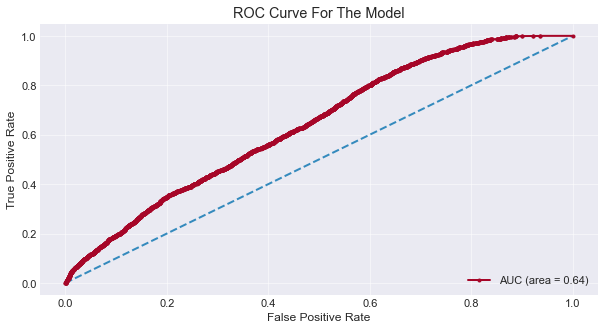

In [64]:
plot_roc_auc(logreg, X_test, y_test)

In [77]:
#instantiate random forest:
rf = RandomForestClassifier()

#training model and printing scores:
model_train_score(rf, X_train, y_train, X_test, y_test)


Training Vs Test Scores: 
test_set R-squared score: 0.8112
train_set R-squared score: 0.9999

Model Performance:
r2_score:  -0.16330845990211107
mean_square_error:  0.1887690085804095


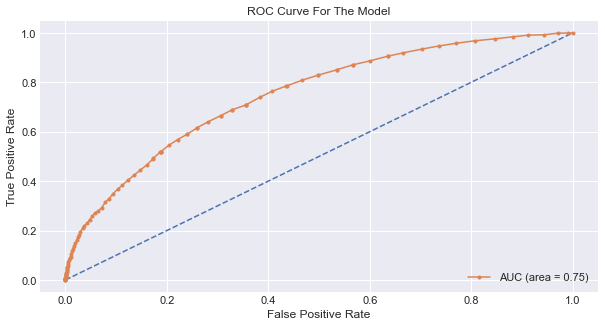

In [78]:
plot_roc_auc(rf, X_test, y_test)

In [96]:
#Confustion Matrix for model: RandomForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


# Printing the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred))

[[9158  214]
 [2045  354]]
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      9372
           1       0.62      0.15      0.24      2399

    accuracy                           0.81     11771
   macro avg       0.72      0.56      0.56     11771
weighted avg       0.78      0.81      0.76     11771



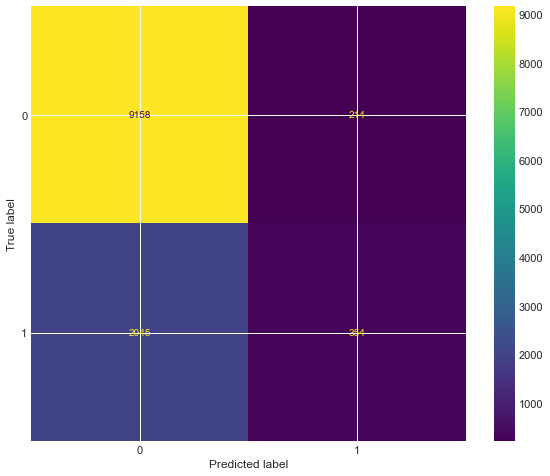

In [97]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
plt.rcParams["figure.figsize"] = [10, 8]
disp_cm.plot() 

### Additional boosting model 

In [74]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(random_state=1)
ada_boost.fit(X_train, y_train)
print(ada_boost.score(X_test,y_test))

0.8074080367003653


In [72]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
grad_boost.fit(X_train, y_train)
grad_boost.score(X_test,y_test)

0.796194036190638